In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [ ]:
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
import jax.numpy as jnp
from numpy.polynomial.legendre import leggauss
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from numpy.random import default_rng
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict


# ==============================================================
# Real Data Analysis Same J
# ==============================================================


In [ ]:
# ============================================
# Real Data: Norwegian Fire Insurance
# ETELN, Same J, θ fixed = 500 kNOK
# ============================================

# --------------------------------------------
# 1) Load data and build the 4 samples
# --------------------------------------------
path = "/content/sample_data/norwegianfire_raw.csv"
df = pd.read_csv(path)
df["year_full"] = 1900 + df["year"].astype(int)

# Cap for “monster” claim
MONSTER_NOK = 2_000_000_000  # 2 billion NOK
MONSTER_kNOK = MONSTER_NOK / 1_000.0

# Strict threshold: keep claims EXCEEDING 500 kNOK
theta_kNOK = 500.0
df_work = df.loc[df["size"] > theta_kNOK].copy()
n_total = len(df)
n_work  = len(df_work)

def q_nearest(x: np.ndarray, p: float) -> float:
    """Robust 'nearest' quantile across pandas/numpy versions."""
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    s = pd.Series(x)
    try:
        return float(s.quantile(p, method="nearest"))
    except TypeError:
        try:
            return float(s.quantile(p, interpolation="nearest"))
        except TypeError:
            try:
                return float(np.quantile(x, p, method="nearest"))
            except TypeError:
                return float(np.percentile(x, 100*p, interpolation="nearest"))

# Headline stats (kNOK)
s = df_work["size"].astype(float)
n = s.size
m1 = s.mean()
q1 = q_nearest(s.values, 0.25)
q3 = q_nearest(s.values, 0.75)

m2 = np.mean((s - m1)**2)
m3 = np.mean((s - m1)**3)
g1 = m3 / (m2**1.5) if m2 > 0 else np.nan
skew_unbiased = (np.sqrt(n*(n-1))/(n-2))*g1 if n > 2 else np.nan

print("=== Norwegian fire insurance (kNOK), strict > 500 ===")
print(f"n_total: {n_total}")
print(f"n_after_theta (x>500): {n_work}")
print(f"year_min_max: ({int(df['year_full'].min())}, {int(df['year_full'].max())})")
print(f"min_kNOK: {s.min():,.0f}")
print(f"max_kNOK: {s.max():,.0f}")
print(f"mean_kNOK: {m1:,.3f}")
print(f"q1_kNOK: {q1:,.0f}")
print(f"q3_kNOK: {q3:,.0f}")
print(f"skewness: {skew_unbiased:.2f}")

# Original data (x > 500)
x_original = np.asarray(df_work["size"].values, dtype=float)
x_original = np.sort(x_original)

# Modified original: replace max by MONSTER_kNOK
x_mod_original = x_original.copy()
imax = np.argmax(x_mod_original)
x_mod_original[imax] = MONSTER_kNOK
x_mod_original = np.sort(x_mod_original)

# Sampled: n=50, seed=123
rng = np.random.default_rng(123)
idx50 = rng.choice(x_original.shape[0], size=50, replace=False)
x_sampled = np.sort(x_original[idx50])

# Modified sampled: replace its max with MONSTER_kNOK
x_mod_sampled = x_sampled.copy()
jmax = np.argmax(x_mod_sampled)
x_mod_sampled[jmax] = MONSTER_kNOK
x_mod_sampled = np.sort(x_mod_sampled)

# θ for ETELN code
θ = theta_kNOK

print(f"\nCounts: {len(x_original)}, {len(x_mod_original)}, {len(x_sampled)}, {len(x_mod_sampled)}")
print(f"Original max -> Modified original max: {np.max(x_original):,.0f} -> {np.max(x_mod_original):,.0f}")
print(f"Sampled max  -> Modified sampled max : {np.max(x_sampled):,.0f}  -> {np.max(x_mod_sampled):,.0f}")
print(f"θ (fixed): {θ:,.0f} kNOK")
print(f"Monster (cap): {MONSTER_kNOK:,.0f} kNOK  = {int(MONSTER_NOK):,} NOK")

def print_sample_block(x, title, rows=5, cols=10, integers=True):
    x = np.sort(np.asarray(x, float))
    if x.size != rows*cols:
        raise ValueError(f"Expected {rows*cols} values, got {x.size}.")
    if integers:
        x_disp = np.round(x).astype(int)
        fmt = lambda v: f"{v:,.0f}"
    else:
        x_disp = x
        fmt = lambda v: f"{v:,.3f}"
    print(title)
    for r in range(rows):
        start = r*cols
        row_vals = [fmt(v) for v in x_disp[start:start+cols]]
        print(", ".join(row_vals))
    print()

print_sample_block(x_sampled,      "Sampled data (n=50, kNOK):")
print_sample_block(x_mod_sampled,  "Modified sampled data (n=50, kNOK):")


=== Norwegian fire insurance (kNOK), strict > 500 ===
n_total: 9181
n_after_theta (x>500): 9020
year_min_max: (1972, 1992)
min_kNOK: 501
max_kNOK: 465,365
mean_kNOK: 2,247.860
q1_kNOK: 711
q3_kNOK: 1,817
skewness: 30.61

Counts: 9020, 9020, 50, 50
Original max -> Modified original max: 465,365 -> 2,000,000
Sampled max  -> Modified sampled max : 4,607  -> 2,000,000
θ (fixed): 500 kNOK
Monster (cap): 2,000,000 kNOK  = 2,000,000,000 NOK
Sampled data (n=50, kNOK):
505, 512, 513, 520, 541, 615, 632, 641, 650, 650
675, 675, 682, 698, 699, 700, 704, 704, 718, 735
745, 805, 822, 901, 911, 942, 957, 961, 1,035, 1,060
1,075, 1,223, 1,244, 1,343, 1,500, 1,743, 1,750, 2,039, 2,072, 2,097
2,139, 2,220, 2,294, 2,348, 2,468, 2,764, 3,317, 3,814, 4,377, 4,607

Modified sampled data (n=50, kNOK):
505, 512, 513, 520, 541, 615, 632, 641, 650, 650
675, 675, 682, 698, 699, 700, 704, 704, 718, 735
745, 805, 822, 901, 911, 942, 957, 961, 1,035, 1,060
1,075, 1,223, 1,244, 1,343, 1,500, 1,743, 1,750, 2,039, 2,

In [ ]:
# --------------------------------------------
# Performance knobs
# --------------------------------------------
try:
    from threadpoolctl import threadpool_limits
    _HAS_TPCTL = True
except Exception:
    _HAS_TPCTL = False

N_JOBS       = -1
BACKEND      = "loky"
BLAS_THREADS = 1

NQUAD_OBS = 800
NQUAD_MC  = 200
GRID_OBS  = 401
GRID_MC   = 201
MC_BATCH  = 200

MC_B_ORIG      = 10000
MC_B_MOD_ORIG  = 10000
MC_B_SAMP      = 2000
MC_B_MOD_SAMP  = 2000

ln2 = np.log(2.0)

# --------------------------------------------
# Generic GoF helpers & printing
# --------------------------------------------
def ks_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); ecdf = (np.arange(1, n+1)) / n
    return float(np.max(np.abs(u - ecdf)))

def cvm_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); i = np.arange(1, n+1)
    return float(np.sum((u - (2*i - 1)/(2*n))**2) + 1.0/(12*n))

def _panel_to_lines_with_spanner(title, rows):
    w = dict(est=20, a=6, b=7, pks=10, dks=8, pcvm=10, wcvm=9)

    def pad(s, width, align="<"):
        return f"{s:{align}{width}}"

    def fmt_p(p, det):
        return f"<{det:.3f}" if (det > 0 and p <= det) else f"{p:.3f}"

    det = rows[0].get("_det", 0.0) if rows else 0.0

    lines = [title]

    top = (
        pad("Estimator", w["est"]) +
        pad("α̂",        w["a"],  ">") +
        pad("β̂",        w["b"],  ">") +
        pad("KS Test",   w["pks"] + w["dks"], ">") +
        pad("CvM",       w["pcvm"] + w["wcvm"], ">")
    )
    sub = (
        pad("",          w["est"]) +
        pad("",          w["a"]) +
        pad("",          w["b"]) +
        pad("p",         w["pks"], ">") +
        pad("D",         w["dks"], ">") +
        pad("p",         w["pcvm"], ">") +
        pad("W",         w["wcvm"], ">")
    )
    lines += [top, sub]

    for r in rows:
        lines.append(
            pad(r["Estimator"],         w["est"]) +
            pad(f"{r['alpha']:.2f}",    w["a"],  ">") +
            pad(f"{r['beta']:.2f}",     w["b"],  ">") +
            pad(fmt_p(r["KS_p"], det),  w["pks"], ">") +
            pad(f"{r['KS_D']:.3f}",     w["dks"], ">") +
            pad(fmt_p(r["CvM_p"], det), w["pcvm"], ">") +
            pad(f"{r['CvM_W']:.3f}",    w["wcvm"], ">")
        )
    return lines

def print_side_by_side_with_spanners(left_title, left_rows, right_title, right_rows):
    L = _panel_to_lines_with_spanner(left_title, left_rows)
    R = _panel_to_lines_with_spanner(right_title, right_rows)
    gap = 3
    left_width = max(len(s) for s in L) + gap
    total_width = left_width + max(len(s) for s in R)
    rule = "=" * total_width
    print("\n" + rule)
    for l, r in zip_longest(L, R, fillvalue=""):
        print(f"{l:<{left_width}}{r}")
    print(rule)

# --------------------------------------------
# ETELN: CDF, sampling, MLE
# --------------------------------------------
def eteln_cdf(x, alpha, beta, theta):
    """
    CDF of ETELN(α, β, θ) with θ fixed; consistent with the simulation transform:
      if β ≈ 0:  F(x) = 1 + log Φ(α log(x/θ)) / log 2
      else:      F(x) = [2^β - Φ(α log(x/θ))^{-β}] / (2^β - 1)
    """
    x = np.asarray(x, float)
    u = np.zeros_like(x, dtype=float)

    m = x > theta
    if not np.any(m):
        return u

    z = alpha * np.log(x[m] / theta)
    G = norm.cdf(z)
    G = np.clip(G, 1e-300, 1.0 - 1e-15)

    if abs(beta) < 1e-8:
        u[m] = 1.0 + np.log(G) / ln2
    else:
        two_b = np.exp(beta * ln2)
        denom = two_b - 1.0
        if abs(denom) < 1e-14:
            denom = beta * ln2 + 0.5 * (beta**2) * (ln2**2)
        u[m] = (two_b - np.power(G, -beta)) / denom

    return np.clip(u, 0.0, 1.0)

def eteln_sample(n, alpha, beta, theta, rng=None):
    """
    Inverse-transform sampling for ETELN, matching your simulation code.
    """
    rng = default_rng() if rng is None else rng
    u = rng.uniform(0.0, 1.0, int(n))

    if abs(beta) < 1e-8:
        u0 = np.exp(-(1.0 - u) * ln2)   # 2^{-(1-u)}
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        u0    = np.power(base, -1.0 / beta)

    u0 = np.clip(u0, 1e-9, 1.0 - 1e-9)
    xi = norm.ppf(u0)
    return theta * np.exp(xi / alpha)

def eteln_loglik_alpha_beta(x, alpha, beta, theta):
    """
    Log-likelihood for ETELN(α, β, θ) with θ fixed
    (mirrors your mle_eteln in the simulation class).
    """
    if alpha <= 0 or np.abs(beta) > 12:
        return -np.inf

    xv = np.asarray(x, float)
    xv = xv[xv > theta]
    if xv.size == 0:
        return -np.inf

    n = xv.size

    if abs(beta) < 1e-8:
        const = -np.log(np.log(2.0))
    else:
        two_b = np.exp(beta * ln2)
        const = np.log(np.abs(beta)) - np.log(np.abs(two_b - 1.0))

    z = alpha * np.log(xv / theta)
    phi_z = norm.pdf(z)
    Phi_z = norm.cdf(z)

    Phi_z = np.maximum(Phi_z, 1e-300)
    phi_z = np.maximum(phi_z, 1e-300)

    ll = (
        n * np.log(alpha) + n * const
        - 0.5 * n * np.log(2.0 * np.pi)
        - np.sum(np.log(xv))
        - 0.5 * alpha**2 * np.sum(np.log(xv / theta)**2)
        - (beta + 1.0) * np.sum(np.log(Phi_z))
    )

    return float(ll) if np.isfinite(ll) else -np.inf

def fit_mle_eteln(x, theta):
    x = np.asarray(x, float)
    x = x[x > theta]
    if x.size < 5:
        return np.nan, np.nan

    lx = np.log(x)
    m1 = lx.mean()
    m2 = (lx**2).mean()
    var = max(m2 - m1**2, 1e-6)
    a0 = max(0.1, 1.0 / np.sqrt(var))
    b0 = 0.5

    def nll(p):
        a, b = p
        v = eteln_loglik_alpha_beta(x, a, b, theta)
        return -v if np.isfinite(v) else 1e20

    res = minimize(
        nll,
        x0=[a0, b0],
        bounds=[(1e-3, 40.0), (-8.0, 8.0)],
        method="L-BFGS-B"
    )
    if res.success:
        return float(res.x[0]), float(res.x[1])

    res = minimize(
        nll,
        x0=[1.5, 0.2],
        bounds=[(1e-3, 40.0), (-8.0, 8.0)],
        method="L-BFGS-B"
    )
    return (float(res.x[0]), float(res.x[1])) if res.success else (np.nan, np.nan)

# --------------------------------------------
# Same-J L-estimation for ETELN
# --------------------------------------------
def _dk_tau(beta, a, b, n_quad):
    """
    For ETELN same-J:
      d1(β) = ∫ J(u;a,b) ξ(u;β) du
      d2(β) = ∫ J(u;a,b) ξ(u;β)^2 du
      τ(β)  = d2(β) - d1(β)^2
    with ξ(u;β) from the ETELN ETE transform.
    """
    nodes, w = np.polynomial.legendre.leggauss(n_quad)
    u = 0.5 * (nodes + 1.0)
    w = 0.5 * w

    J = a * b * (u**(a - 1.0)) * ((1.0 - u**a)**(b - 1.0))

    if abs(beta) < 1e-10:
        u0 = np.exp(-(1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        u0    = np.power(base, -1.0 / beta)

    u0 = np.clip(u0, 1e-9, 1.0 - 1e-9)
    xi = norm.ppf(u0)

    d1 = float(np.sum(w * J * xi))
    d2 = float(np.sum(w * J * (xi**2)))
    tau = d2 - d1**2
    return d1, max(tau, 1e-14)

def fit_L_eteln_stable(x, a=1.1, b=1.2, theta=500.0,
                       n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    """
    Same-J L-estimator for ETELN:
      (μ1 - log θ)/sqrt(Δ) = d1(β)/sqrt(τ(β)),
    then α̂ = sqrt(τ̂/Δ).
    """
    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n < 5:
        return np.nan, np.nan

    xs = np.sort(x)
    i = np.arange(1, n + 1)
    uo = i / (n + 1.0)

    Jw = a * b * (uo**(a - 1.0)) * ((1.0 - uo**a)**(b - 1.0))
    wts = Jw / np.sum(Jw)

    lx = np.log(xs)
    mu1 = float(np.sum(wts * lx))
    mu2 = float(np.sum(wts * (lx**2)))
    Delta = max(mu2 - mu1**2, 1e-12)

    target = (mu1 - np.log(theta)) / np.sqrt(Delta)

    def R(beta):
        d1, tau = _dk_tau(beta, a, b, n_quad=n_quad)
        return d1 / np.sqrt(tau) - target

    grid = np.linspace(-10.0, 10.0, int(root_grid))
    vals = np.array([R(bi) for bi in grid])
    sgn = np.sign(vals)

    beta_hat = None
    for k in range(len(grid) - 1):
        if (np.isfinite(vals[k]) and np.isfinite(vals[k + 1]) and
                sgn[k] * sgn[k + 1] < 0):
            beta_hat = brentq(R, grid[k], grid[k + 1],
                              xtol=1e-8, maxiter=400)
            break

    if beta_hat is None:
        def obj(b):
            rb = R(b)
            return (rb if np.isfinite(rb) else 1e6)**2
        res = minimize_scalar(
            obj,
            bounds=(-10.0, 10.0),
            method="bounded",
            options={"xatol": 1e-8, "maxiter": 1000}
        )
        beta_hat = float(res.x)

    _, tau_hat = _dk_tau(beta_hat, a, b, n_quad=n_quad)
    alpha_hat = np.sqrt(tau_hat / Delta)
    return float(alpha_hat), float(beta_hat)

def make_safe_L_factory_eteln(a_req, b_req, fallbacks=None,
                              n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    if fallbacks is None:
        fallbacks = [(1.05, 1.10), (1.10, 1.20), (1.20, 1.30)]

    def fit_fun(z, _nq=n_quad, _rg=root_grid):
        ah, bh = fit_L_eteln_stable(z, a_req, b_req, θ,
                                    n_quad=_nq, root_grid=_rg)
        if np.isfinite(ah) and np.isfinite(bh):
            return ah, bh

        for (aa, bb) in fallbacks:
            ah2, bh2 = fit_L_eteln_stable(z, aa, bb, θ,
                                          n_quad=_nq, root_grid=_rg)
            if np.isfinite(ah2) and np.isfinite(bh2):
                return ah2, bh2

        return fit_mle_eteln(z, θ)

    return fit_fun

# --------------------------------------------
# Monte Carlo p-values for ETELN
# --------------------------------------------
def mc_pvals_parallel_eteln(x, fit_fun, theta, B=2000, seed=1234,
                            n_jobs=N_JOBS, backend=BACKEND,
                            nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC,
                            grid_obs=GRID_OBS, grid_mc=GRID_MC,
                            batch=MC_BATCH):
    if _HAS_TPCTL:
        threadpool_limits(BLAS_THREADS)

    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    def fit_obs(z):
        return fit_fun(z, _nq=nquad_obs, _rg=grid_obs)

    a_hat, b_hat = fit_obs(x)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = eteln_sample(n, a_hat, b_hat, theta, rng)
        ah, bh = fit_fun(xb, _nq=nquad_mc, _rg=grid_mc)
        cdf_b = lambda z, aa=ah, bb=bh: eteln_cdf(z, aa, bb, theta)
        return ks_statistic(xb, cdf_b), cvm_statistic(xb, cdf_b)

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds))
        Ws_all.append(np.array(Ws))

    Ds = np.concatenate(Ds_all)
    Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

def mc_pvals_fixedparams_eteln(x, fit_fun, theta, B=10000, seed=1234,
                               n_jobs=N_JOBS, backend=BACKEND,
                               nquad_obs=NQUAD_OBS, batch=MC_BATCH):
    if _HAS_TPCTL:
        threadpool_limits(BLAS_THREADS)

    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    a_hat, b_hat = fit_fun(x, _nq=nquad_obs, _rg=GRID_OBS)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = eteln_sample(n, a_hat, b_hat, theta, rng)
        return ks_statistic(xb, cdf_hat), cvm_statistic(xb, cdf_hat)

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds))
        Ws_all.append(np.array(Ws))

    Ds = np.concatenate(Ds_all)
    Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# --------------------------------------------
# GoF wrapper & panel builder for ETELN
# --------------------------------------------
def gof_with_mode_eteln(x, fit_fun, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    x = np.asarray(x, float)
    x = x[x > θ]
    if x.size == 0:
        return {
            "Estimator": "", "alpha": np.nan, "beta": np.nan,
            "KS_p": np.nan, "KS_D": np.nan,
            "CvM_p": np.nan, "CvM_W": np.nan,
            "_det": 1.0 / (B + 1.0)
        }

    if mode == "mc_fixed":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_fixedparams_eteln(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs,
            nquad_obs=NQUAD_OBS, batch=MC_BATCH
        )
        return {
            "Estimator": "", "alpha": a_hat, "beta": b_hat,
            "KS_p": p_ks, "KS_D": D_obs,
            "CvM_p": p_cvm, "CvM_W": W_obs,
            "_det": 1.0 / (B + 1.0)
        }

    if mode == "mc":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_parallel_eteln(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs,
            nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC,
            grid_obs=GRID_OBS, grid_mc=GRID_MC
        )
        return {
            "Estimator": "", "alpha": a_hat, "beta": b_hat,
            "KS_p": p_ks, "KS_D": D_obs,
            "CvM_p": p_cvm, "CvM_W": W_obs,
            "_det": 1.0 / (B + 1.0)
        }

    # asymptotic fallback (not used in your MC design)
    a_hat, b_hat = fit_fun(x)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, θ)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)
    p_ks = float(kstwobign.sf(np.sqrt(x.size) * D_obs))
    u = eteln_cdf(np.sort(x), a_hat, b_hat, θ)
    p_cvm = float(cramervonmises(u, uniform.cdf).pvalue)
    return {
        "Estimator": "", "alpha": a_hat, "beta": b_hat,
        "KS_p": p_ks, "KS_D": D_obs,
        "CvM_p": p_cvm, "CvM_W": W_obs,
        "_det": 0.0
    }

def build_panel_eteln(x, estimators, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    rows = []
    for (name, fit_fun) in estimators:
        r = gof_with_mode_eteln(x, fit_fun, mode=mode, B=B, seed=seed, n_jobs=n_jobs)
        r["Estimator"] = name
        rows.append(r)
    return rows

# --------------------------------------------
# Estimator lists (same J grid as ETLL)
# --------------------------------------------
estimators_orig_eteln = [
    ("MLE",           lambda z, **kw: fit_mle_eteln(z, θ)),
    ("J(1.30,1.60)",  make_safe_L_factory_eteln(1.30, 1.60)),
]

estimators_samp_eteln = [
    ("MLE",             lambda z, **kw: fit_mle_eteln(z, θ)),
    ("J(1.30,1.40)",    make_safe_L_factory_eteln(1.30, 1.40,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.25,2.00)",    make_safe_L_factory_eteln(1.25, 2.00,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.50,1.60)",    make_safe_L_factory_eteln(1.50, 1.60,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.00,2.00)",    make_safe_L_factory_eteln(1.00, 2.00,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.35,3.50)",    make_safe_L_factory_eteln(1.35, 3.50,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.25,9.00)",    make_safe_L_factory_eteln(1.25, 9.00,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.40,1.40)",    make_safe_L_factory_eteln(1.40, 1.40,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.30,1.60)",    make_safe_L_factory_eteln(1.30, 1.60,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(0.80,2.00)",    make_safe_L_factory_eteln(0.80, 2.00,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(2.00,0.80)",    make_safe_L_factory_eteln(2.00, 0.80,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.15,4.00)",    make_safe_L_factory_eteln(1.15, 4.00,
                               fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
]

# --------------------------------------------
# MAIN: run ETELN panels only
# --------------------------------------------
if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    t0 = time.perf_counter()

    # Full-sample: fixed-parameter MC
    panel_original_eteln   = build_panel_eteln(
        x_original,     estimators_orig_eteln, mode="mc_fixed",
        B=MC_B_ORIG,     seed=3031, n_jobs=N_JOBS
    )
    panel_mod_orig_eteln   = build_panel_eteln(
        x_mod_original, estimators_orig_eteln, mode="mc_fixed",
        B=MC_B_MOD_ORIG, seed=3032, n_jobs=N_JOBS
    )

    # n=50: refitting MC
    panel_sampled_eteln    = build_panel_eteln(
        x_sampled,      estimators_samp_eteln, mode="mc",
        B=MC_B_SAMP,     seed=3033, n_jobs=N_JOBS
    )
    panel_mod_sample_eteln = build_panel_eteln(
        x_mod_sampled,  estimators_samp_eteln, mode="mc",
        B=MC_B_MOD_SAMP, seed=3034, n_jobs=N_JOBS
    )

    print_side_by_side_with_spanners(
        "Original Data (θ = 500)", panel_original_eteln,
        "Modified Original Data ", panel_mod_orig_eteln
    )
    print_side_by_side_with_spanners(
        "Sampled Data (n=50)", panel_sampled_eteln,
        "Modified Sampled Data", panel_mod_sample_eteln
    )

    print(f"\n⏱️ block runtime: {time.perf_counter() - t0:.2f} s")



Original Data (θ = 500)                                                  Modified Original Data 
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
                                          p       D         p        W                                             p       D         p        W
MLE                   0.71   0.16    <0.000   0.028    <0.000    2.779   MLE                   0.71   0.17    <0.000   0.028    <0.000    2.825
J(1.30,1.60)          0.78  -0.27     0.001   0.021     0.001    1.278   J(1.30,1.60)          0.78  -0.27     0.000   0.021     0.000    1.279

Sampled Data (n=50)                                                      Modified Sampled Data
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
                                          p       D         p        W                

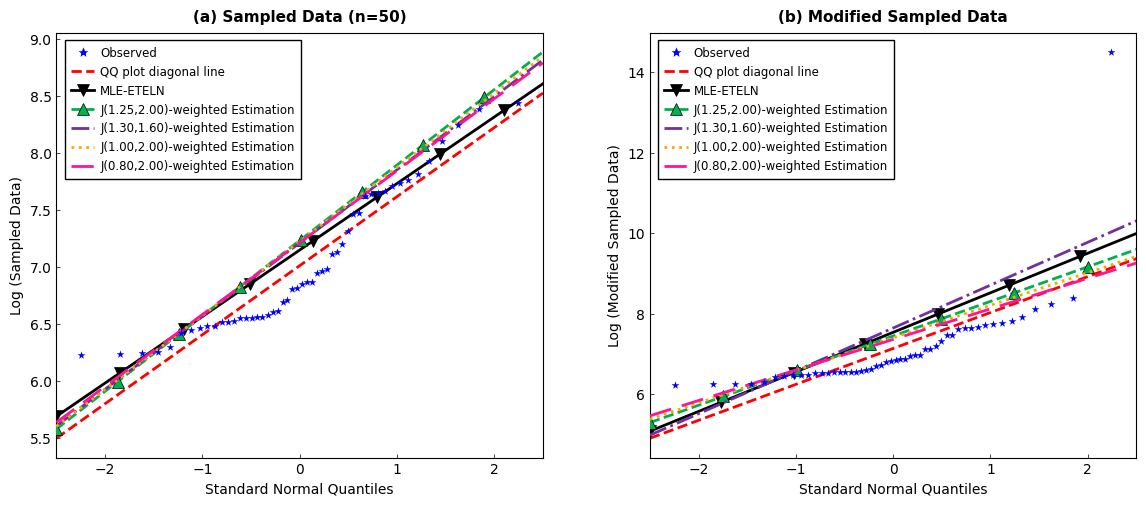


⏱️ ETELN figure block runtime: 268.03 s


In [ ]:
# ============================================================
# QQ-plot for ETELN (same style as ETELL figure)
# ============================================================

ln2 = np.log(2.0)  # safe to re-define

# -------------------- ETELN quantile (PPF) --------------------
def eteln_ppf(u, alpha, beta, theta):
    """
    Quantile function of ETELN(α, β, θ), consistent with your ETELN sampler.
    """
    u = np.clip(np.asarray(u, float), 1e-12, 1.0 - 1e-12)

    if abs(beta) < 1e-8:
        # β ≈ 0 limit
        u0 = np.exp(-(1.0 - u) * ln2)       # 2^{-(1-u)}
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        u0    = np.power(base, -1.0 / beta)

    u0 = np.clip(u0, 1e-9, 1.0 - 1e-9)
    xi = norm.ppf(u0)
    return theta * np.exp(xi / alpha)

# -------------------- Which ETELN models to show --------------------
# You can tweak these J(a,b) choices later if you decide on different "BEST" weights.
MODELS_SAMPLED_ETELN = [
    ("MLE",          lambda z: fit_mle_eteln(z, θ)),
    ("J(1.25,2.00)", make_safe_L_factory_eteln(1.25, 2.00)),  # BEST1
    ("J(1.30,1.60)", make_safe_L_factory_eteln(1.30, 1.60)),  # BEST2
    ("J(1.00,2.00)", make_safe_L_factory_eteln(1.00, 2.00)),  # BEST3
    ("J(0.80,2.00)", make_safe_L_factory_eteln(0.80, 2.00)),  # BEST4
]

MODELS_MODIFIED_ETELN = [
    ("MLE",          lambda z: fit_mle_eteln(z, θ)),
    ("J(1.25,2.00)", make_safe_L_factory_eteln(1.25, 2.00)),  # BEST1
    ("J(1.30,1.60)", make_safe_L_factory_eteln(1.30, 1.60)),  # BEST2
    ("J(1.00,2.00)", make_safe_L_factory_eteln(1.00, 2.00)),  # BEST3
    ("J(0.80,2.00)", make_safe_L_factory_eteln(0.80, 2.00)),  # BEST4
]

# -------------------- House style map (same colors as ETELL) --------------------
STYLE_ORDER_ETELN = ["MLE", "BEST1", "BEST2", "BEST3", "BEST4"]

STYLE_MAP_ETELN = {
    "MLE": dict(
        color="black", linestyle="-", linewidth=2.0, marker="v",
        markersize=8, markevery=0.12, markeredgewidth=0.5,
        markeredgecolor="black", label="MLE-ETELN"
    ),
    "BEST1": dict(
        color="#00B050", linestyle="--", linewidth=2.0, marker="^",
        markersize=8, markevery=0.12, markeredgewidth=0.5,
        markeredgecolor="black",
        label_fmt=lambda n: f"{n}-weighted Estimation"   # bright green
    ),
    "BEST2": dict(
        color="#7030A0", linestyle="-.", linewidth=2.0, marker=None,
        label_fmt=lambda n: f"{n}-weighted Estimation"   # purple
    ),
    "BEST3": dict(
        color="#FFA500", linestyle=":", linewidth=2.0, marker=None,
        label_fmt=lambda n: f"{n}-weighted Estimation"   # orange
    ),
    "BEST4": dict(
        color="#FF1493", linestyle=(0, (8, 4)), linewidth=2.0, marker=None,
        label_fmt=lambda n: f"{n}-weighted Estimation"   # pink
    ),
}

# -------------------- Helpers (Blom + proxy line) --------------------
def blom_positions(n: int):
    """Blom plotting positions (gentler tails than i/(n+1))."""
    i = np.arange(1, n+1)
    return (i - 0.375) / (n + 0.25)

def model_proxy_line_eteln(alpha, beta, theta, z_min=-2.5, z_max=2.5, m=400):
    """
    Best straight line A + B z approximating log q_model(p) vs z
    for ETELN, on [z_min, z_max].
    """
    z_grid = np.linspace(z_min, z_max, m)
    p_grid = norm.cdf(z_grid)
    q_grid = eteln_ppf(p_grid, alpha, beta, theta)
    y_grid = np.log(q_grid)
    B, A = np.polyfit(z_grid, y_grid, 1)  # slope, intercept
    return A, B

# -------------------- QQ panel for ETELN --------------------
def qq_panel_eteln(ax, x, model_list, panel_title, y_label):
    x = np.sort(np.asarray(x, float))
    n = x.size

    # Points: Blom positions -> normal quantiles
    u = blom_positions(n)
    z = norm.ppf(u)
    y_obs = np.log(x)

    # Observed points
    ax.scatter(z, y_obs, s=35, alpha=1.0, color="blue", marker="*",
               label="Observed", zorder=5, linewidth=0)

    # Data "QQ diagonal": OLS line through (z, log x)
    B_data, A_data = np.polyfit(z, y_obs, 1)
    z_line = np.linspace(-2.5, 2.5, 200)
    ax.plot(z_line, A_data + B_data*z_line, "--", linewidth=2.0, color="red",
            zorder=2, label="QQ plot diagonal line")

    # Model overlays
    legend_handles, legend_labels = [], []
    for idx, (name, fit_fun) in enumerate(model_list):
        a_hat, b_hat = fit_fun(x)
        if not (np.isfinite(a_hat) and np.isfinite(b_hat)):
            continue

        style_key = STYLE_ORDER_ETELN[idx] if idx < len(STYLE_ORDER_ETELN) else "BEST4"
        st = STYLE_MAP_ETELN[style_key]

        A_m, B_m = model_proxy_line_eteln(a_hat, b_hat, θ, z_line.min(), z_line.max())

        line_kwargs = dict(
            color=st["color"],
            linestyle=st["linestyle"],
            linewidth=st["linewidth"],
            zorder=3
        )

        if st.get("marker") is not None:
            line_kwargs.update({
                "marker": st["marker"],
                "markersize": st.get("markersize", 8),
                "markevery": st.get("markevery", 0.12),
                "markeredgewidth": st.get("markeredgewidth", 0.5),
                "markeredgecolor": st.get("markeredgecolor", "black"),
                "markerfacecolor": st["color"],
            })

        line = ax.plot(z_line, A_m + B_m*z_line, **line_kwargs)[0]

        # Label
        if "label" in st:
            label = st["label"]
        else:
            label = st["label_fmt"](name)

        legend_handles.append(line)
        legend_labels.append(label)

    # Cosmetics
    ax.set_title(panel_title, fontsize=11, fontweight="bold", pad=8)
    ax.set_xlabel("Standard Normal Quantiles", fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.grid(False)
    ax.set_facecolor("white")
    ax.tick_params(direction="in", length=3, width=0.5)
    ax.set_axisbelow(True)
    ax.set_xlim(z_line.min(), z_line.max())
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(0.8)

    # Legend
    obs_handle  = plt.Line2D([0], [0], marker="*",
                             color="w", markerfacecolor="blue",
                             markersize=10, linestyle="",
                             label="Observed")
    diag_handle = plt.Line2D([0], [0], color="red",
                             linewidth=2.0, linestyle="--",
                             label="QQ plot diagonal line")

    all_handles = [obs_handle, diag_handle] + legend_handles
    all_labels  = ["Observed", "QQ plot diagonal line"] + legend_labels
    ax.legend(all_handles, all_labels,
              loc="upper left", bbox_to_anchor=(0.01, 0.99),
              fontsize=8.5, frameon=True, fancybox=False, framealpha=1.0,
              edgecolor="black", borderpad=0.5, columnspacing=1.0,
              handletextpad=0.5, borderaxespad=0.3)

# -------------------- Two-panel ETELN figure --------------------
t0 = time.perf_counter()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor("white")
plt.subplots_adjust(left=0.08, right=0.98, top=0.95,
                    bottom=0.1, wspace=0.22)

qq_panel_eteln(axes[0], x_sampled,     MODELS_SAMPLED_ETELN,
               "(a) Sampled Data (n=50)", "Log (Sampled Data)")
qq_panel_eteln(axes[1], x_mod_sampled, MODELS_MODIFIED_ETELN,
               "(b) Modified Sampled Data", "Log (Modified Sampled Data)")

for fmt, dpi in [("pdf", None), ("png", 300),('eps', 300)]:
    plt.savefig(f"fig_style_ETELN_manyL.{fmt}",
                format=fmt, dpi=dpi,
                bbox_inches="tight",
                facecolor="white", edgecolor="white")

plt.show()
print(f"\n⏱️ ETELN figure block runtime: {time.perf_counter() - t0:.2f} s")


# ==============================================================
# Real Data Analysis Different J
# ==============================================================


In [ ]:
# ==============================================================
# DESIGN B: Real Data Analysis - Norwegian Fire Insurance (ETELN)
# Different J (J₁ ≠ J₂), Same h = log(x)
# ==============================================================


# --------------------------------------------
# PERFORMANCE KNOBS
# --------------------------------------------
try:
    from threadpoolctl import threadpool_limits
    _HAS_TPCTL = True
except Exception:
    _HAS_TPCTL = False

N_JOBS       = -1
BACKEND      = "loky"
BLAS_THREADS = 1

NQUAD_OBS = 800
NQUAD_MC  = 200
GRID_OBS  = 401
GRID_MC   = 201
MC_BATCH  = 200

MC_B_ORIG      = 10000
MC_B_MOD_ORIG  = 10000
MC_B_SAMP      = 2000
MC_B_MOD_SAMP  = 2000

ln2 = np.log(2.0)

# --------------------------------------------
# BASIC GoF HELPERS
# --------------------------------------------
def ks_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); ecdf = (np.arange(1, n+1)) / n
    return float(np.max(np.abs(u - ecdf)))

def cvm_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); i = np.arange(1, n+1)
    return float(np.sum((u - (2*i - 1)/(2*n))**2) + 1.0/(12*n))

# --------------------------------------------
# ETELN CDF
# --------------------------------------------
def eteln_cdf(x, alpha, beta, theta):
    x = np.asarray(x, float)
    u = np.zeros_like(x)
    m = x > theta
    if not np.any(m):
        return u

    z = alpha * np.log(x[m] / theta)
    G = np.clip(norm.cdf(z), 1e-300, 1 - 1e-15)

    if abs(beta) < 1e-10:
        u[m] = 1.0 + np.log(G) / ln2
    else:
        two_b = np.exp(beta * ln2)
        denom = two_b - 1.0
        if abs(denom) < 1e-14:
            denom = beta * ln2 + 0.5 * (beta**2) * (ln2**2)
        u[m] = (two_b - G**(-beta)) / denom

    return np.clip(u, 0.0, 1.0)

# --------------------------------------------
# ETELN SAMPLING
# --------------------------------------------
def eteln_sample(n, alpha, beta, theta, rng=None):
    rng = default_rng() if rng is None else rng
    u = rng.uniform(0.0, 1.0, int(n))

    if abs(beta) < 1e-10:
        u0 = np.exp(-(1.0 - u) * ln2)    # 2^{-(1-u)}
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        u0    = base**(-1.0 / beta)

    u0 = np.clip(u0, 1e-12, 1.0 - 1e-12)
    xi = norm.ppf(u0)
    return theta * np.exp(xi / alpha)

# --------------------------------------------
# ETELN LOG-LIKELIHOOD & MLE
# --------------------------------------------
def eteln_loglik_alpha_beta(x, alpha, beta, theta):
    if alpha <= 0 or abs(beta) > 12:
        return -np.inf

    xv = np.asarray(x, float)
    xv = xv[xv > theta]
    if xv.size == 0:
        return -np.inf
    n = xv.size

    if abs(beta) < 1e-10:
        const = -np.log(np.log(2.0))
    else:
        two_b = np.exp(beta * ln2)
        const = np.log(abs(beta)) - np.log(abs(two_b - 1.0))

    z     = alpha * np.log(xv / theta)
    Phi_z = np.maximum(norm.cdf(z), 1e-300)

    ll = (
        n * np.log(alpha) + n * const
        - 0.5 * n * np.log(2.0 * np.pi)
        - np.sum(np.log(xv))
        - 0.5 * alpha**2 * np.sum(np.log(xv / theta)**2)
        - (beta + 1.0) * np.sum(np.log(Phi_z))
    )

    return float(ll) if np.isfinite(ll) else -np.inf

def fit_mle_eteln(x, theta):
    x = np.asarray(x, float)
    x = x[x > theta]
    if x.size < 5:
        return np.nan, np.nan

    lx  = np.log(x)
    var = max(np.var(lx), 1e-6)
    a0  = max(0.1, 1.0 / np.sqrt(var))
    b0  = 0.5

    def nll(p):
        a, b = p
        v = eteln_loglik_alpha_beta(x, a, b, theta)
        return -v if np.isfinite(v) else 1e20

    res = minimize(
        nll, x0=[a0, b0],
        bounds=[(1e-3, 40.0), (-8.0, 8.0)],
        method="L-BFGS-B"
    )
    if res.success:
        return float(res.x[0]), float(res.x[1])

    # backup start
    res = minimize(
        nll, x0=[1.5, 0.2],
        bounds=[(1e-3, 40.0), (-8.0, 8.0)],
        method="L-BFGS-B"
    )
    return (float(res.x[0]), float(res.x[1])) if res.success else (np.nan, np.nan)

# --------------------------------------------
# DESIGN B — CORE INTEGRALS FOR ETELN
# --------------------------------------------
def _cw_designB_eteln(beta, a1, b1, a2, b2, n_quad):
    """
    J1(a1,b1), J2(a2,b2), ETELN latent ξ(u;β) = Φ^{-1}(u0(β,u))
      c1 = ∫ J1 ξ,  c2 = ∫ J2 ξ,  c_w = c2 - c1
    """
    nodes, w = np.polynomial.legendre.leggauss(n_quad)
    u = 0.5 * (nodes + 1.0)
    w = 0.5 * w

    J1 = a1*b1 * (u**(a1-1.0)) * ((1.0 - u**a1)**(b1-1.0))
    J2 = a2*b2 * (u**(a2-1.0)) * ((1.0 - u**a2)**(b2-1.0))

    # Latent ξ(u;β) from ETELN transform
    if abs(beta) < 1e-10:
        u0 = np.exp(-(1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        u0    = base**(-1.0 / beta)

    u0 = np.clip(u0, 1e-12, 1.0 - 1e-12)
    xi = norm.ppf(u0)

    c1 = float(np.sum(w * J1 * xi))
    c2 = float(np.sum(w * J2 * xi))
    cw = c2 - c1
    return c1, c2, cw

# --------------------------------------------
# DESIGN B L-ESTIMATOR (ETELN)
# --------------------------------------------
def fit_L_eteln_designB_stable(x, a1, b1, a2, b2,
                               theta=500.0,
                               n_quad=NQUAD_OBS,
                               root_grid=GRID_OBS):

    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n < 5:
        return np.nan, np.nan

    xs = np.sort(x)
    uo = np.arange(1, n+1) / (n+1.0)

    J1 = a1*b1 * (uo**(a1-1.0)) * ((1.0 - uo**a1)**(b1-1.0))
    J2 = a2*b2 * (uo**(a2-1.0)) * ((1.0 - uo**a2)**(b2-1.0))

    # Normalize separately (Design B)
    J1 = J1 / np.sum(J1)
    J2 = J2 / np.sum(J2)

    lx   = np.log(xs)
    mu1  = float(np.sum(J1 * lx))
    mu2  = float(np.sum(J2 * lx))
    Delta_w = mu2 - mu1
    if abs(Delta_w) < 1e-12:
        return np.nan, np.nan

    def Psi(beta):
        c1, c2, cw = _cw_designB_eteln(beta, a1, b1, a2, b2, n_quad)
        if abs(cw) < 1e-14:
            return np.nan
        return c1/cw + (np.log(theta) - mu1) / Delta_w

    grid = np.linspace(-10.0, 10.0, int(root_grid))
    vals = np.array([Psi(bi) for bi in grid])
    sgn  = np.sign(vals)

    beta_hat = None
    for k in range(len(grid)-1):
        if (np.isfinite(vals[k]) and np.isfinite(vals[k+1]) and
                sgn[k]*sgn[k+1] < 0):
            try:
                beta_hat = brentq(Psi, grid[k], grid[k+1],
                                  xtol=1e-8, maxiter=500)
                break
            except Exception:
                continue

    if beta_hat is None:
        def obj(b):
            val = Psi(b)
            return (val if np.isfinite(val) else 1e6)**2
        res = minimize_scalar(
            obj, bounds=(-10.0, 10.0),
            method="bounded",
            options={"xatol": 1e-8, "maxiter": 1000}
        )
        beta_hat = float(res.x)

    _, _, cw_hat = _cw_designB_eteln(beta_hat, a1, b1, a2, b2, n_quad)
    alpha_hat = cw_hat / Delta_w

    if alpha_hat <= 0:
        return np.nan, np.nan

    return float(alpha_hat), float(beta_hat)

# --------------------------------------------
# SAFE FACTORY FOR DESIGN B ETELN
# --------------------------------------------
def make_safe_L_designB_factory_eteln(a1, b1, a2, b2,
                                      fallbacks=None,
                                      n_quad=NQUAD_OBS,
                                      root_grid=GRID_OBS):

    if fallbacks is None:
        fallbacks = [
            ((1.0,1.0),(1.0,2.0)),
            ((1.0,1.0),(2.0,1.0)),
            ((1.0,1.0),(1.5,1.5)),
        ]

    def fit_fun(z, _nq=n_quad, _rg=root_grid):
        ah, bh = fit_L_eteln_designB_stable(
            z, a1, b1, a2, b2,
            theta=θ, n_quad=_nq, root_grid=_rg
        )
        if np.isfinite(ah) and np.isfinite(bh):
            return ah, bh

        for (p1, p2) in fallbacks:
            ah2, bh2 = fit_L_eteln_designB_stable(
                z, p1[0], p1[1], p2[0], p2[1],
                theta=θ, n_quad=_nq, root_grid=_rg
            )
            if np.isfinite(ah2) and np.isfinite(bh2):
                return ah2, bh2

        return fit_mle_eteln(z, θ)

    return fit_fun

# --------------------------------------------
# MC: FIXED-PARAMETER (FULL SAMPLE) FOR DESIGN B ETELN
# --------------------------------------------
def mc_pvals_fixedparams_designB_eteln(x, fit_fun, theta,
                                       B=10000, seed=1234,
                                       n_jobs=N_JOBS, backend=BACKEND,
                                       nquad_obs=NQUAD_OBS,
                                       batch=MC_BATCH):
    if _HAS_TPCTL:
        threadpool_limits(BLAS_THREADS)

    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    # Fit once
    a_hat, b_hat = fit_fun(x, _nq=nquad_obs, _rg=GRID_OBS)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, theta)
    D_obs   = ks_statistic(x, cdf_hat)
    W_obs   = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = eteln_sample(n, a_hat, b_hat, theta, rng)
        return ks_statistic(xb, cdf_hat), cvm_statistic(xb, cdf_hat)

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds))
        Ws_all.append(np.array(Ws))

    Ds = np.concatenate(Ds_all)
    Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# --------------------------------------------
# MC: RE-FITTING (n=50 PANELS) FOR DESIGN B ETELN
# --------------------------------------------
def mc_pvals_parallel_designB_eteln(x, fit_fun, theta,
                                    B=2000, seed=1234,
                                    n_jobs=N_JOBS, backend=BACKEND,
                                    nquad_obs=NQUAD_OBS,
                                    nquad_mc=NQUAD_MC,
                                    grid_obs=GRID_OBS,
                                    grid_mc=GRID_MC,
                                    batch=MC_BATCH):
    if _HAS_TPCTL:
        threadpool_limits(BLAS_THREADS)

    x = np.asarray(x, float)
    x = x[x > theta]
    n = x.size
    if n == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    def fit_obs(z):
        return fit_fun(z, _nq=nquad_obs, _rg=grid_obs)

    a_hat, b_hat = fit_obs(x)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, theta)
    D_obs   = ks_statistic(x, cdf_hat)
    W_obs   = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb  = eteln_sample(n, a_hat, b_hat, theta, rng)
        ah, bh = fit_fun(xb, _nq=nquad_mc, _rg=grid_mc)
        cdf_b = lambda z, aa=ah, bb=bh: eteln_cdf(z, aa, bb, theta)
        return ks_statistic(xb, cdf_b), cvm_statistic(xb, cdf_b)

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds))
        Ws_all.append(np.array(Ws))

    Ds = np.concatenate(Ds_all)
    Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# --------------------------------------------
# GOF WRAPPER (ETELN Design B)
# --------------------------------------------
def gof_with_mode_designB_eteln(x, fit_fun, mode="mc_fixed",
                                B=10000, seed=2025, n_jobs=N_JOBS):
    x = np.asarray(x, float)
    x = x[x > θ]
    if x.size == 0:
        return {
            "Estimator": "", "alpha": np.nan, "beta": np.nan,
            "KS_p": np.nan, "KS_D": np.nan,
            "CvM_p": np.nan, "CvM_W": np.nan,
            "_det": 1.0 / (B + 1.0)
        }

    if mode == "mc_fixed":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_fixedparams_designB_eteln(
            x, fit_fun, θ, B=B, seed=seed,
            n_jobs=n_jobs, nquad_obs=NQUAD_OBS, batch=MC_BATCH
        )
        return {
            "Estimator": "", "alpha": a_hat, "beta": b_hat,
            "KS_p": p_ks, "KS_D": D_obs,
            "CvM_p": p_cvm, "CvM_W": W_obs,
            "_det": 1.0 / (B + 1.0)
        }

    if mode == "mc":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_parallel_designB_eteln(
            x, fit_fun, θ, B=B, seed=seed,
            n_jobs=n_jobs,
            nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC,
            grid_obs=GRID_OBS, grid_mc=GRID_MC,
            batch=MC_BATCH
        )
        return {
            "Estimator": "", "alpha": a_hat, "beta": b_hat,
            "KS_p": p_ks, "KS_D": D_obs,
            "CvM_p": p_cvm, "CvM_W": W_obs,
            "_det": 1.0 / (B + 1.0)
        }

    # asymptotic fallback (rarely used)
    a_hat, b_hat = fit_fun(x)
    cdf_hat = lambda z: eteln_cdf(z, a_hat, b_hat, θ)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)
    p_ks  = float(kstwobign.sf(np.sqrt(x.size) * D_obs))
    u     = eteln_cdf(np.sort(x), a_hat, b_hat, θ)
    p_cvm = float(cramervonmises(u, uniform.cdf).pvalue)
    return {
        "Estimator": "", "alpha": a_hat, "beta": b_hat,
        "KS_p": p_ks, "KS_D": D_obs,
        "CvM_p": p_cvm, "CvM_W": W_obs,
        "_det": 0.0
    }

# --------------------------------------------
# PANEL BUILDER + PRINTING
# --------------------------------------------
def build_panel_designB_eteln(x, estimators, mode="mc_fixed",
                              B=10000, seed=2025, n_jobs=N_JOBS):
    rows = []
    for (name, fit_fun) in estimators:
        r = gof_with_mode_designB_eteln(
            x, fit_fun, mode=mode, B=B, seed=seed, n_jobs=n_jobs
        )
        r["Estimator"] = name
        rows.append(r)
    return rows

def _panel_to_lines_with_spanner(title, rows):
    w = dict(est=20, a=6, b=7, pks=10, dks=8, pcvm=10, wcvm=9)

    def pad(s, width, align="<"):
        return f"{s:{align}{width}}"

    def fmt_p(p, det):
        return f"<{det:.3f}" if (det > 0 and p <= det) else f"{p:.3f}"

    det = rows[0].get("_det", 0.0) if rows else 0.0

    lines = [title]

    top = (
        pad("Estimator", w["est"]) +
        pad("α̂",        w["a"],  ">") +
        pad("β̂",        w["b"],  ">") +
        pad("KS Test",   w["pks"] + w["dks"], ">") +
        pad("CvM",       w["pcvm"] + w["wcvm"], ">")
    )
    sub = (
        pad("",          w["est"]) +
        pad("",          w["a"]) +
        pad("",          w["b"]) +
        pad("p",         w["pks"], ">") +
        pad("D",         w["dks"], ">") +
        pad("p",         w["pcvm"], ">") +
        pad("W",         w["wcvm"], ">")
    )
    lines += [top, sub]

    for r in rows:
        lines.append(
            pad(r["Estimator"],         w["est"]) +
            pad(f"{r['alpha']:.2f}",    w["a"],  ">") +
            pad(f"{r['beta']:.2f}",     w["b"],  ">") +
            pad(fmt_p(r["KS_p"], det),  w["pks"], ">") +
            pad(f"{r['KS_D']:.3f}",     w["dks"], ">") +
            pad(fmt_p(r["CvM_p"], det), w["pcvm"], ">") +
            pad(f"{r['CvM_W']:.3f}",    w["wcvm"], ">")
        )
    return lines

def print_side_by_side_with_spanners(left_title, left_rows,
                                     right_title, right_rows):
    L = _panel_to_lines_with_spanner(left_title, left_rows)
    R = _panel_to_lines_with_spanner(right_title, right_rows)
    gap = 3
    left_width = max(len(s) for s in L) + gap
    total_width = left_width + max(len(s) for s in R)
    rule = "=" * total_width
    print("\n" + rule)
    for l, r in zip_longest(L, R, fillvalue=""):
        print(f"{l:<{left_width}}{r}")
    print(rule)

# --------------------------------------------
# ESTIMATOR LISTS (Design B, ETELN)
# --------------------------------------------
# Full-sample: MLE + Design-B J2(3,12) with J1(11,6)
estimators_orig_designB_eteln = [
    ("MLE",          lambda z, **kw: fit_mle_eteln(z, θ)),
    ("J₂(3.0,12.0)", make_safe_L_designB_factory_eteln(11.0, 6.0, 3.0, 12.0)),
]

# n=50: MLE + a grid of J2 values with J1(1,1) — mirror ETLL Design B
estimators_samp_designB_eteln = [
    ("MLE",            lambda z, **kw: fit_mle_eteln(z, θ)),
    ("J₂(1.0,2.0)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 1.0, 2.0)),
    ("J₂(2.0,1.0)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 2.0, 1.0)),
    ("J₂(1.9,1.1)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 1.9, 1.1)),
    ("J₂(2.2,1.1)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 2.2, 1.1)),
    ("J₂(2.4,1.2)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 2.4, 1.2)),
    ("J₂(1.5,1.0)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 1.5, 1.0)),
    ("J₂(2.0,1.1)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 2.0, 1.1)),
    ("J₂(1.2,1.8)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 1.2, 1.8)),
    ("J₂(1.8,1.1)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 1.8, 1.1)),
    ("J₂(2.2,1.2)",    make_safe_L_designB_factory_eteln(1.0, 1.0, 2.2, 1.2)),
]

# --------------------------------------------
# MAIN: RUN ALL 4 PANELS
# --------------------------------------------
if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    print("\n" + "="*80)
    print("RUNNING ETELN DESIGN-B ANALYSIS...")
    print("="*80)

    t0 = time.perf_counter()

    # Full-sample panels: FIXED-PARAMETER MC
    panel_original_eteln_designB = build_panel_designB_eteln(
        x_original, estimators_orig_designB_eteln,
        mode="mc_fixed", B=MC_B_ORIG, seed=3031, n_jobs=N_JOBS
    )
    panel_mod_orig_eteln_designB = build_panel_designB_eteln(
        x_mod_original, estimators_orig_designB_eteln,
        mode="mc_fixed", B=MC_B_MOD_ORIG, seed=3032, n_jobs=N_JOBS
    )

    # n=50 panels: RE-FITTING MC
    panel_sampled_eteln_designB = build_panel_designB_eteln(
        x_sampled, estimators_samp_designB_eteln,
        mode="mc", B=MC_B_SAMP, seed=3033, n_jobs=N_JOBS
    )
    panel_mod_sample_eteln_designB = build_panel_designB_eteln(
        x_mod_sampled, estimators_samp_designB_eteln,
        mode="mc", B=MC_B_MOD_SAMP, seed=3034, n_jobs=N_JOBS
    )

    print("\n" + "="*80)
    print("NORWEGIAN FIRE INSURANCE — ETELN DESIGN B")
    print("="*80)

    print_side_by_side_with_spanners(
        "Original Data (θ = 500)", panel_original_eteln_designB,
        "Modified Original Data",  panel_mod_orig_eteln_designB
    )
    print_side_by_side_with_spanners(
        "Sampled Data (n=50)",     panel_sampled_eteln_designB,
       "Modified Sampled Data",   panel_mod_sample_eteln_designB
    )

    print(f"\n⏱️ ETELN Design-B block runtime: {time.perf_counter() - t0:.2f} s")


RUNNING ETELN DESIGN-B ANALYSIS...

NORWEGIAN FIRE INSURANCE — ETELN DESIGN B

Original Data (θ = 500)                                                  Modified Original Data
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
                                          p       D         p        W                                             p       D         p        W
MLE                   0.71   0.16    <0.000   0.028    <0.000    2.779   MLE                   0.71   0.17    <0.000   0.028    <0.000    2.825
J₂(3.0,12.0)          0.82  -0.56     0.002   0.019     0.006    0.799   J₂(3.0,12.0)          0.82  -0.56     0.002   0.019     0.007    0.799

Sampled Data (n=50)                                                      Modified Sampled Data
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
        

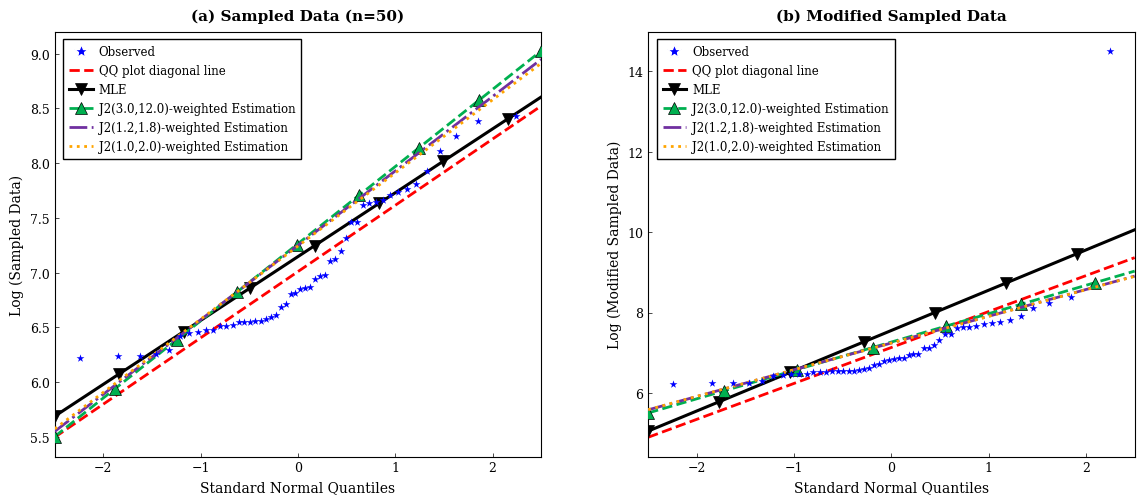


⏱️ ETELN Design-B Q-Q figure block runtime: 186.75 s


In [ ]:
# ==============================================================
# ETELN Design-B Q-Q plots for sampled / modified sampled data
# ==============================================================

# ---------- Matplotlib ----------
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'axes.grid': False,
})

# ---------- Globals ----------
θ  = 500.0       # make sure this matches your data threshold
ln2 = np.log(2.0)

# ==============================================================
# 1) ETELN QUANTILE FUNCTION (PPF) – consistent with eteln_sample
# ==============================================================

def eteln_ppf(u, alpha, beta, theta):
    """
    Inverse CDF for ETELN(α, β, θ), consistent with your eteln_sample:
      1. map u -> u0 via the β-transform
      2. xi = Φ^{-1}(u0)
      3. x = θ * exp(xi / α)
    """
    u = np.clip(np.asarray(u, float), 1e-12, 1.0 - 1e-12)

    if abs(beta) < 1e-10:
        # β ≈ 0 limit
        u0 = np.exp(-(1.0 - u) * ln2)   # 2^{-(1-u)}
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.clip(base, 1e-300, None)
        u0    = base**(-1.0 / beta)

    u0 = np.clip(u0, 1e-12, 1.0 - 1e-12)
    xi = norm.ppf(u0)
    return theta * np.exp(xi / alpha)

# ==============================================================
# 2) DESIGN B MODELS FOR ETELN (same set on both panels)
#    J1 is fixed at (11, 6) from your Design-B setup
# ==============================================================

_models_designB_eteln = [
    ("MLE",          lambda z: fit_mle_eteln(z, θ)),
    ("J2(3.0,12.0)", make_safe_L_designB_factory_eteln(11.0, 6.0, 3.0, 12.0)),
    ("J2(1.2,1.8)",  make_safe_L_designB_factory_eteln(11.0, 6.0, 1.2, 1.8)),
    ("J2(1.0,2.0)",  make_safe_L_designB_factory_eteln(11.0, 6.0, 1.0, 2.0)),
]

# de-duplicate & keep order if you tweak later
models_designB_eteln = list(OrderedDict((k, v) for k, v in _models_designB_eteln).items())

# ---------- Style map (ETELN) ----------
STYLE_MAP_ETELN = {
    "MLE":           dict(color="black",   linestyle="-",      linewidth=2.2,
                          marker="v", markersize=8, markevery=0.12,
                          markeredgewidth=0.5, markeredgecolor='black',
                          label="MLE"),
    "J2(3.0,12.0)":  dict(color="#00B050", linestyle="--",     linewidth=2.0,
                          marker="^", markersize=8, markevery=0.12,
                          markeredgewidth=0.5, markeredgecolor='black',
                          label="J2(3.0,12.0)-weighted Estimation"),
    "J2(1.2,1.8)":   dict(color="#7030A0", linestyle="-.",     linewidth=2.0,
                          marker=None,
                          label="J2(1.2,1.8)-weighted Estimation"),
    "J2(1.0,2.0)":   dict(color="#FFA500", linestyle=":",      linewidth=2.0,
                          marker=None,
                          label="J2(1.0,2.0)-weighted Estimation"),
}

# ==============================================================
# 3) Helpers for straight proxy lines + plotting positions
# ==============================================================

def blom_positions(n: int):
    i = np.arange(1, n+1)
    return (i - 0.375) / (n + 0.25)

def model_proxy_line_eteln(alpha, beta, theta, z_min=-2.5, z_max=2.5, m=400):
    """
    Least-squares straight line A + B z approximating log q_model(p)
    for the ETELN quantile over z ∈ [z_min, z_max].
    """
    z_grid = np.linspace(z_min, z_max, m)
    p_grid = norm.cdf(z_grid)
    y_grid = np.log(eteln_ppf(p_grid, alpha, beta, theta))
    B, A = np.polyfit(z_grid, y_grid, 1)   # slope, intercept
    return A, B

# ==============================================================
# 4) ETELN Design-B QQ panel (publication style)
# ==============================================================

def qq_panel_publication_eteln(ax, x, panel_title=None, y_label="Log (Data)"):
    x = np.sort(np.asarray(x, float))
    n = x.size
    u = blom_positions(n)
    z = norm.ppf(u)
    y_obs = np.log(x)

    # Observed points (blue stars)
    ax.scatter(z, y_obs, s=35, color='blue', marker='*',
               zorder=5, linewidth=0, label='Observed')

    # Data QQ diagonal (red dashed)
    B_data, A_data = np.polyfit(z, y_obs, 1)
    z_line = np.linspace(-2.5, 2.5, 220)
    ax.plot(z_line, A_data + B_data*z_line, '--', color='red',
            linewidth=2.0, zorder=2, label='QQ plot diagonal line')

    # Model straight proxy lines (ETELN)
    legend_handles, legend_labels = [], []
    for name, fit_fun in models_designB_eteln:
        a_hat, b_hat = fit_fun(x)
        if not (np.isfinite(a_hat) and np.isfinite(b_hat)):
            continue

        st = STYLE_MAP_ETELN[name]
        A_m, B_m = model_proxy_line_eteln(a_hat, b_hat, θ,
                                          z_min=z_line.min(), z_max=z_line.max())

        line_kwargs = {
            'color': st['color'],
            'linestyle': st['linestyle'],
            'linewidth': st['linewidth'],
            'zorder': 3,
        }

        if st.get('marker') is not None:
            line_kwargs.update({
                'marker': st['marker'],
                'markersize': st.get('markersize', 8),
                'markevery': st.get('markevery', 0.12),
                'markeredgewidth': st.get('markeredgewidth', 0.5),
                'markeredgecolor': st.get('markeredgecolor', 'black'),
                'markerfacecolor': st['color'],
            })

        line = ax.plot(z_line, A_m + B_m*z_line, **line_kwargs)[0]
        legend_handles.append(line)
        legend_labels.append(st['label'])

    # Cosmetics
    if panel_title:
        ax.set_title(panel_title, fontsize=11, fontweight='bold', pad=8)
    ax.set_xlabel("Standard Normal Quantiles", fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_facecolor('white')
    ax.tick_params(direction='in', length=3, width=0.5)
    ax.set_axisbelow(True)
    ax.set_xlim(z_line.min(), z_line.max())
    for sp in ax.spines.values():
        sp.set_edgecolor('black')
        sp.set_linewidth(0.8)

    # Legend
    obs_handle  = plt.Line2D([0], [0], marker='*', color='w',
                             markerfacecolor='blue', markersize=10,
                             linestyle='', label='Observed')
    diag_handle = plt.Line2D([0], [0], color='red', linewidth=2.0,
                             linestyle='--', label='QQ plot diagonal line')

    ax.legend(
        [obs_handle, diag_handle] + legend_handles,
        ['Observed', 'QQ plot diagonal line'] + legend_labels,
        loc='upper left', bbox_to_anchor=(0.01, 0.99),
        fontsize=8.5,
        frameon=True, fancybox=False, framealpha=1.0,
        edgecolor='black', borderpad=0.5,
        columnspacing=1.0, handletextpad=0.5,
        borderaxespad=0.3
    )

# ==============================================================
# 5) Build the two-panel ETELN Design-B figure
#    (x_sampled and x_mod_sampled already defined in your notebook)
# ==============================================================

t0 = time.perf_counter()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('white')
plt.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.1, wspace=0.22)

qq_panel_publication_eteln(
    axes[0], x_sampled,
    "(a) Sampled Data (n=50)", "Log (Sampled Data)"
)
qq_panel_publication_eteln(
    axes[1], x_mod_sampled,
    "(b) Modified Sampled Data", "Log (Modified Sampled Data)"
)

for fmt, dpi in [('pdf', None), ('png', 300),('eps', 300)]:
    plt.savefig(f'fig_designB_qq_ETELN.{fmt}', format=fmt, dpi=dpi,
                bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

print(f"\n⏱️ ETELN Design-B Q-Q figure block runtime: {time.perf_counter() - t0:.2f} s")
